In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from tqdm import tqdm_notebook as tqdm

import tensorflow as tf
import h5py

In [2]:
def min_dist_angle(position, direction, box_size):
    #which wall is it close to?
    x, y = position
    dists = [box_size-x, box_size-y, box_size+x, box_size+y]
    d_wall = np.min(dists)
    angles = np.arange(4)*np.pi/2
    theta = angles[np.argmin(dists)]
    a_wall = direction - theta
    a_wall = (a_wall + np.pi) % (2*np.pi) - np.pi
    return d_wall, a_wall

In [3]:
def min_dist_angle_circular(position, direction, box_size):
    #which wall is it close to?
    x, y = position
    r = np.sqrt(x**2 + y**2)
    d_wall = box_size - r

    # find nearest point on circle
    x_circ = x*box_size / r
    y_circ = y*box_size / r

    # compute angle to this point
    theta = np.arctan2(y_circ, x_circ) % (2*np.pi)

    # subtract from head direction to get a_wall
    a_wall = direction - theta
    a_wall = (a_wall + np.pi) % (2*np.pi) - np.pi
    
    return d_wall, a_wall

In [5]:
# Set up trajectory params
dt = 0.02  # time step increment (seconds)
samples = int(2/dt) + 1  # number of time points
box_size = 1.1 #meters
border_region = 0.03  # meters

turn_angle = 0

mu = 0
sigma = 5.76#stdev rotation velocity (rads/sec)
b = 0.13  #forward velocity rayleigh dist scale (m/sec)

In [6]:
# random velocity samples
def generate_trajectory():
    v = np.random.rayleigh(b);
    #initialize variables
    position = np.zeros([samples+1, 2])
    head_dir = np.zeros(samples+1)
    turning = np.zeros(samples+1, dtype='bool')
    
#     # For generating circular trajectory
#     init_rad = np.random.uniform(0, 1.1)
#     init_ang = np.random.uniform(0, 2*np.pi)
    
    position[0] = np.random.uniform(-box_size, box_size, 2)
    head_dir[0] = np.random.uniform(0,2*np.pi)
    ego_v = np.zeros(samples+1)
    
    #generate sequence of random boosts and turns
    random_turn = np.random.normal(mu, sigma, samples+1)
    random_vel = np.random.rayleigh(b, samples+1)
    
    for i in range(1,samples+1):
        #If in border region, turn and slow down
        d_wall, a_wall = min_dist_angle(position[i-1], head_dir[i-1] % (2*np.pi), box_size)
        if d_wall < border_region and np.abs(a_wall) < np.pi/2:
            turning[i-1] = 1 
            turn_angle = np.sign(a_wall)* (np.pi/2 - np.abs(a_wall)) + dt*random_turn[i]
            v = 0.25*v
        else:
            v = random_vel[i]
            turn_angle = dt*random_turn[i]
        #Take a step
        ego_v[i-1] = v*dt
        position[i] = position[i-1] + ego_v[i-1]*np.asarray([np.cos(head_dir[i-1]), np.sin(head_dir[i-1])])
        #Rotate head direction
        head_dir[i] = (head_dir[i-1] + turn_angle) 
    ang_velocity = np.diff(head_dir)
    theta_x, theta_y = np.cos(ang_velocity), np.sin(ang_velocity)
    head_dir = (head_dir +np.pi) % (2*np.pi) - np.pi #Constrain head_dir to interval (-pi, pi)
    return position[:-1,0], position[:-1, 1], head_dir[:-1], ego_v[:-1], theta_x, theta_y, turning[:-1]

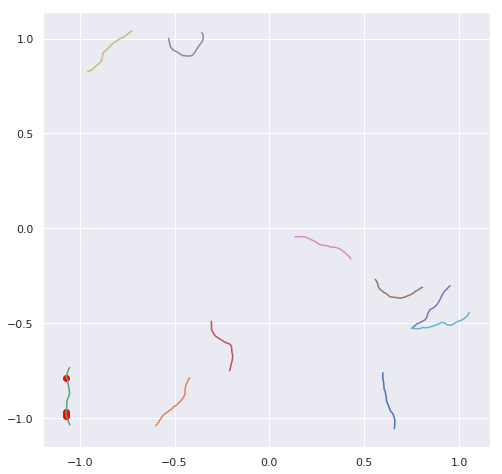

In [7]:
plt.figure(figsize=(8,8))
for i in range(10):
    sample_traj = generate_trajectory()
    x = sample_traj[0]
    y = sample_traj[1]
    turning = sample_traj[-1]
    plt.plot(x, y)
    plt.scatter(x[turning], y[turning], c='red')
    
plt.axis("equal")    
t = np.linspace(-np.pi, np.pi, 100)
# plt.plot(box_size*np.cos(t), box_size*np.sin(t))

In [39]:
import os
os.mkdir('ben_100_slow_10_boxes')

In [37]:
box_sizes = 1.1 * np.linspace(0.2,2, 10)
np.random.shuffle(box_sizes)

In [8]:
# Generate dataset
def _floats_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

num_files = 100
num_trajectories = 100
for i in tqdm(range(num_files)):
    root = ''
    filename = root + 'ben_100_slow/' + str(i) + '.tfrecord'
#     box_size = 1.1
#     box_size = box_sizes[i]
#     sigma = 5.76 * np.mod(i, 2)
    with tf.python_io.TFRecordWriter(filename) as writer:
        for j in range(num_trajectories):
            traj = np.asarray(generate_trajectory())
#             traj = traj[:,::10] # Decimate to approximately match deepmind

            feature = {
                'init_x': _floats_feature([traj[0][0]]),
                'init_y': _floats_feature([traj[1][0]]),
                'init_hd': _floats_feature([traj[2][0]]),
                'ego_v': _floats_feature(traj[3][:-1]),
                'theta_x': _floats_feature(traj[4][:-1]),
                'theta_y': _floats_feature(traj[5][:-1]),
                'target_x': _floats_feature(traj[0][1:]),
                'target_y': _floats_feature(traj[1][1:]),
                'target_hd': _floats_feature(traj[2][1:])
            }

            example = tf.train.Example(features=tf.train.Features(feature=feature))
            writer.write(example.SerializeToString())
